In [1]:
#importing modules
import argparse
import pandas as pd
import re
import os
import numpy as np
import itertools
from scipy import stats
from tqdm import tqdm
import ast
import sys
import seaborn as sns
import scipy.spatial.distance as scipy_dist
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

from scipy.spatial.distance import squareform
sys.path.append("../src/seq_space_lib/")
import sequence_space_lib as seqsp

sys.path.append("../src/simulate_prot_evol_lib/")
#import simulate_prot_evol_lib as simevol

from sequence_space_lib import matrix_to_array
    


# Correlation dimension measurement principle: comparing points to sequences

Figure 2

In [4]:
# functions to display points

def connect_random_pairs(ax, x, y, z, n_lines=10, color="gray", alpha=0.3):
    n = len(x)
    for _ in range(n_lines):
        i, j = np.random.randint(0, n, 2)  # pick two random indices
        ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]],
                color=color, alpha=alpha, lw=1)

def add_shadows(ax, x, y, z, color="grey", alpha=0.1, s=10):
    """Add projection shadows of each point onto XY, XZ, and YZ planes"""
    # onto XY plane (z=0)
    ax.scatter(x, y, np.zeros_like(z), color=color, alpha=alpha, s=s)
    # onto XZ plane (y=0)
    ax.scatter(x, np.zeros_like(y), z, color=color, alpha=alpha, s=s)
    # onto YZ plane (x=0)
    ax.scatter(np.zeros_like(x), y, z, color=color, alpha=alpha, s=s)

# helper to draw projections
def add_projections(ax, x, y, z, color="gray", alpha=0.2):
    for xi, yi, zi in zip(x, y, z):
        ax.plot([xi, xi], [yi, yi], [0, zi], color=color, alpha=alpha)  # to XY plane
        ax.plot([xi, xi], [0, yi], [zi, zi], color=color, alpha=alpha)  # to XZ plane
        ax.plot([0, xi], [yi, yi], [zi, zi], color=color, alpha=alpha)  # to YZ plane

In [5]:
#functions to generate points on a sphere

rng = np.random.default_rng(42)  # random number generator

def sample_circle(n, R=1.0, center=(0.0, 0.0), bias = False):
    """Uniform points on a 2D circle (circumference)."""
    if bias:
        centers = [0, np.pi/2, np.pi, 3*np.pi/2]  # cluster centers
        cluster = np.random.choice(centers, size=n)
        theta = np.random.normal(cluster, 0.2)  # spread around chosen centers
        x = np.cos(theta)
        y = np.sin(theta)
    else:
        theta = rng.uniform(0, 2*np.pi, n)
        x = R * np.cos(theta) + center[0]
        y = R * np.sin(theta) + center[1]
    return np.column_stack([x, y])

def sample_sphere_surface(n, R=1.0, center=(0.0, 0.0, 0.0)):
    """Uniform points on a 3D sphere surface."""
    #normalize Gaussian vectors
    xyz = rng.normal(size=(n, 3))
    xyz /= np.linalg.norm(xyz, axis=1, keepdims=True)
    xyz = R * xyz
    return xyz + np.asarray(center)

def sample_sphere_volume(n, R=1.0, center=(0.0, 0.0, 0.0)):
    """Uniform points inside a 3D sphere (by volume)."""
    # Direction ~ uniform on S^2
    dirs = rng.normal(size=(n, 3))
    dirs /= np.linalg.norm(dirs, axis=1, keepdims=True)
    # Radius with CDF r^3/R^3  -> r = R * U^(1/3)
    r = R * rng.random(n) ** (1/3)
    pts = dirs * r[:, None]
    return pts + np.asarray(center)

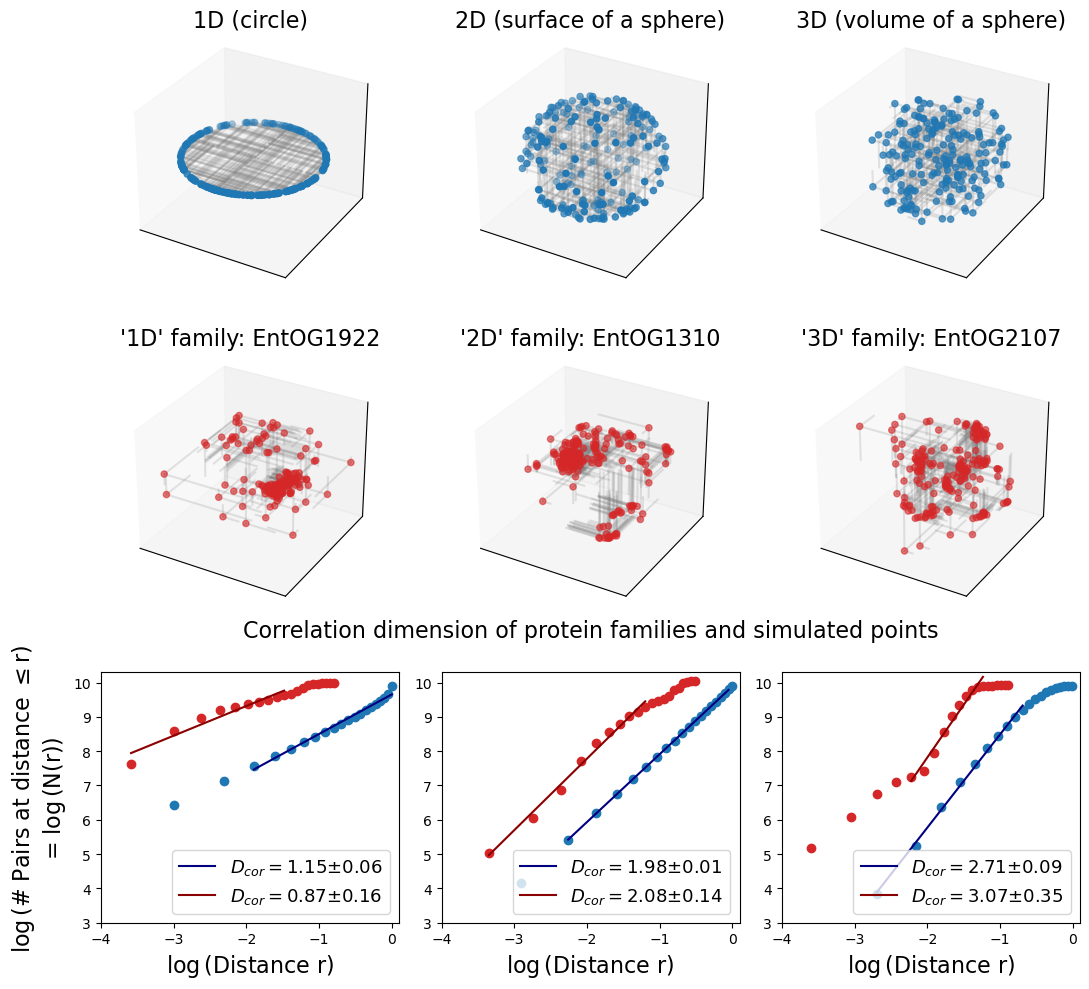

In [8]:

color='tab:blue'

fig = plt.figure(figsize=(11, 10))
npoints = 200
regrange=0.9

ylim=(3,10.3)
xlim=(-4, 0.1)

# Circle (2D)
C = sample_circle(npoints, R=0.5, bias=False)
# Sphere surface (3D)
Ssurf = sample_sphere_surface(npoints, R=0.5)
# Sphere volume (3D)
Svol = sample_sphere_volume(npoints, R=0.5)

# ---------- Top row: 3D point clouds ----------
ax1 = fig.add_subplot(3, 3, 1, projection="3d")
#t = np.random.rand(1, npoints)
#x,y,z=t,np.zeros_like(t),np.zeros_like(t) 
x, y, z = C[:,0], C[:,1], np.zeros_like(C[:,0])
ax1.set_box_aspect((1, 1, 0.8), zoom=1.05)
ax1.scatter(x, y, z, c=color, s=20)
add_projections(ax1, x.ravel(), y, z)
#add_shadows(ax1, x, y, z)
ax1.set_title("1D (circle)", size=16)
ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])

# distances -> bottom-left
points = np.column_stack((x.ravel(), y.ravel(), z.ravel()))
D = distance_matrix(points, points)
ax12 = fig.add_subplot(3, 3, 4+3)  # 2D axis
dim, dimr2, dimci=seqsp.max_k(squareform(D), win_size_perc=regrange, numbins=20,
            plot=True, flat=True, reg_range_from_data=True,
            ci_r2_out_flat=True, ax=ax12, ylim=ylim, xlim=xlim, regcolor='navy', 
            norange=True, legendsize=12, fontsize=14, ylabel=r'log (Pairs at distance $\leq$ r)', xlabel=r'log (Distance r)')

#ax12.set_title(str(dim*np.log10(max(squareform(D)))))

# 2D in XY plane
ax2 = fig.add_subplot(3, 3, 2, projection="3d")
x, y, z = Ssurf[:,0], Ssurf[:,1 ], Ssurf[:,2]
#z = np.zeros_like(x)
ax2.set_box_aspect((1, 1, 0.8), zoom=1.05)
ax2.scatter(x, y, z, c=color, s=20)
add_projections(ax2, x, y, z)
#add_shadows(ax2, x, y, z)
ax2.set_title("2D (surface of a sphere)", size=16)
ax2.set_xticks([]); ax2.set_yticks([]); ax2.set_zticks([])

# distances -> bottom-middle
points = np.column_stack((x.ravel(), y.ravel(), z.ravel()))
D = distance_matrix(points, points)
ax22 = fig.add_subplot(3, 3, 5+3)  # 2D axis
seqsp.max_k(squareform(D), win_size_perc=regrange, numbins=20,
            plot=True, flat=True, reg_range_from_data=True,
            ci_r2_out_flat=True, ax=ax22, ylim=ylim, xlim=xlim, regcolor='navy', 
            norange=True, legendsize=12, fontsize=14,  ylabel=r'log (Pairs at distance $\leq$ r)', xlabel=r'log (Distance r)')
ax22.set_title('Correlation dimension of protein families and simulated points\n', size=16)


# 3D in a cube
ax3 = fig.add_subplot(3, 3, 3, projection="3d")
ax3.set_box_aspect((1, 1, 0.8), zoom=1.05)
x, y, z = Svol[:,0], Svol[:,1 ], Svol[:,2]
ax3.scatter(x, y, z, c=color, s=20, alpha=0.7)
add_projections(ax3, x, y, z)
#add_shadows(ax3, x, y, z)
ax3.set_title("3D (volume of a sphere)", size=16)
ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])


# distances -> bottom-right
points = np.column_stack((x.ravel(), y.ravel(), z.ravel()))
D = distance_matrix(points, points)
ax32 = fig.add_subplot(3, 3, 6+3)  # 2D axis
seqsp.max_k(squareform(D), win_size_perc=0.5, numbins=20,
            plot=True, flat=True, reg_range_from_data=True,
            ci_r2_out_flat=True, ax=ax32, ylim=ylim, xlim=xlim,  regcolor='navy',
            norange=True, legendsize=12, fontsize=14,  ylabel=r'$\log$(Pairs at distance $\leq$ r)', xlabel=r'$\log$(Distance r)')

regax=[ax12, ax22, ax32]
for ind, i in enumerate(['EntOG1922', 'EntOG1310', 'EntOG2107']):
    file='../data/examples/'+i+'.fasta.pdistm'
    tansf=seqsp.MDS_graph(file, n_components=3, noplot=True)
    ax=fig.add_subplot(3,3,ind+4, projection='3d')
    ax.set_box_aspect((1, 1, 0.8), zoom=1.05)
    ax.scatter(tansf.T[0], tansf.T[1], tansf.T[2], c='tab:red', alpha=0.6)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    #connect_random_pairs(ax, tansf.T[0], tansf.T[1], tansf.T[2], n_lines=npoints*2)
    #add_shadows(ax, tansf.T[0], tansf.T[1], tansf.T[2])
    add_projections(ax, tansf.T[0], tansf.T[1], tansf.T[2])
    ax.set_title("'{}D' family: ".format(ind+1)+ i, size=16)
    #dim
    if ind==0:
        ylab=r'$\log$(# Pairs at distance $\leq$r)'+'\n'+r'= $\log$(N(r))'
    else:
        ylab=None
    seqsp.max_k(file, win_size_perc=0.5, numbins=20,
            plot=True, flat=False, reg_range_from_data=True,
            ci_r2_out_flat=True, ax=regax[ind], ylim=ylim, xlim=xlim, regcolor='darkred', scattercolor='tab:red', 
            norange=True, legendsize=13, fontsize=16, ylabel=ylab, xlabel=r'$\log$(Distance r)')

plt.tight_layout()
#plt.savefig('../figures/corr_dim_scheme_simulated_and_real_entero_largefont.png', dpi=300)
plt.show()

# Correlation dimension on points generated in N-dimensional space

Figure S1

In [133]:
# functions to generate points in Euclidean space

def create_normal_matrix(dims, size=4000):
    '''
    creates a matrix of the different distances of points normally distributed on 'dims' dimensions and of size 'size'.
    '''
    eucl_coords_by_dim=[]    
    for dim in range(1, dims+1):
        eucl_coords_by_dim.append(np.random.normal(0,1,size))
    eucl_coords_by_pt=np.array(eucl_coords_by_dim).T
    dist_arr=scipy_dist.pdist(eucl_coords_by_pt)
    dist_norm=dist_arr/max(dist_arr)
    
    return(dist_norm, size)


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


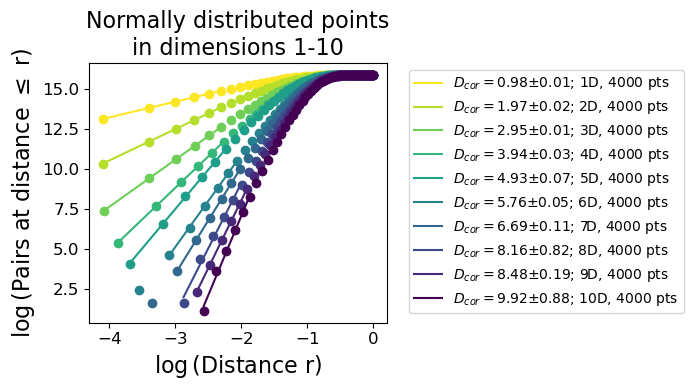

In [ ]:
#one case for every dimension 
colors=['#fde725','#b5de2b','#6ece58','#35b779','#1f9e89','#26828e','#31688e','#3e4989','#482878','#440154']
matrices=[]
fig, ax=plt.subplots(figsize=(7, 4))
for i in tqdm(range(1,11)):
    matrices.append(create_normal_matrix(i, size=4000))
    seqsp.max_k(matrices[-1], win_size_perc=0.10, numbins=60,
            plot=True, flat=True, reg_range_from_data=True,
            ci_r2_out_flat=True, ax=ax, regcolor=colors[i-1], scattercolor=colors[i-1],
            norange=True, legendsize=14, fontsize=16,  ylabel=r'$\log$(Pairs at distance $\leq$ r)', xlabel=r'$\log$(Distance r)', label='; '+str(i)+'D, '+'4000'+' pts')
    ax.legend(bbox_to_anchor=(1.05, 1))
    #seqsp.max_k(matrices[-1],mode='max', flat=True, plot=True, log=False, from_file=False, win_size_perc=0.2, numbins=20,label=str(i)+'D, '+'4000'+' pts', norm=False)
plt.title('Normally distributed points\nin dimensions 1-10', size=16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()

In [ ]:
dims200=[]
for i in tqdm(range(1,11)):
    for j in range(10):
        matrix=create_normal_matrix(i, size=200)
        dim, _, _ = seqsp.max_k(matrix, win_size_perc=0.1, numbins=60,
                plot=False, flat=True, reg_range_from_data=True,
                ci_r2_out_flat=True)
        dims200.append(dim)

100%|██████████| 10/10 [00:00<00:00, 24.06it/s]


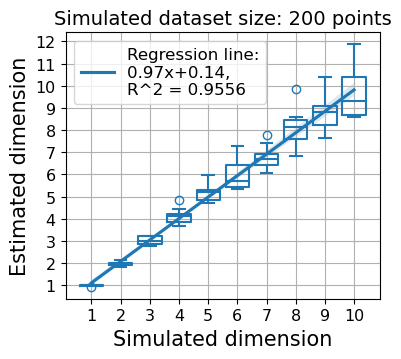

In [ ]:

fig, ax = plt.subplots(figsize=(4, 3.7))
df200=pd.DataFrame(dict({'dim':dims200, 'expected':sorted([1,2,3,4,5,6,7,8, 9,10]*10)}))
df200['expected_idx'] = df200['expected'].astype('category').cat.codes

x = df200['expected'].values
y = df200['dim'].values
slope, b, r_value, p_value, std_err =  stats.linregress(x, y)
if b>0:
    sign='+'
else:
    sign='-'

sns.boxplot(data=df200, x='expected', y='dim', ax=ax, fill=False)
sns.regplot(data=df200, x='expected_idx', y='dim', ax=ax, scatter=False, label = "Regression line:\n"+f'{slope:.2}'+'x'+sign+f'{abs(b):.2},'+' \nR^2 = '+f'{r_value**2:.4}')

ax.set_ylabel('Estimated dimension', size=15)
ax.set_xlabel('Simulated dimension', size=15)
ax.set_yticks(range(1, 13))

ax.grid(True) 
ax.tick_params(axis='both', which='major', labelsize=11.5)

ax.legend(fontsize=12)
plt.title('Simulated dataset size: 200 points', size=14)

plt.tight_layout()





In [ ]:
#10 cases for every dimension 

dims4000=[]
for i in tqdm(range(1,11)):
    for j in range(10):
        matrix=create_normal_matrix(i, size=4000)
        dim, _, _ = seqsp.max_k(matrix, win_size_perc=0.1, numbins=60,
                plot=False, flat=True, reg_range_from_data=True,
                ci_r2_out_flat=True)
        dims4000.append(dim)



100%|██████████| 10/10 [01:42<00:00, 10.20s/it]


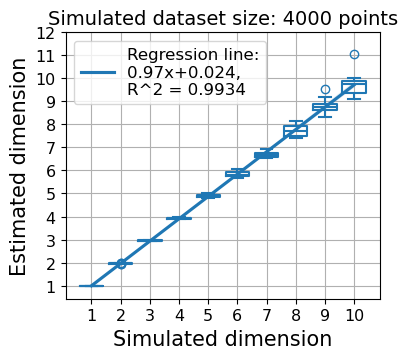

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3.7))
df4000=pd.DataFrame(dict({'dim':dims4000, 'expected':sorted([1,2,3,4,5,6,7,8, 9,10]*10)}))
df4000['expected_idx'] = df4000['expected'].astype('category').cat.codes

x = df4000['expected'].values
y = df4000['dim'].values
slope, b, r_value, p_value, std_err =  stats.linregress(x, y)
if b>0:
    sign='+'
else:
    sign=''

sns.boxplot(data=df4000, x='expected', y='dim', ax=ax, fill=False)
sns.regplot(data=df4000, x='expected_idx', y='dim', ax=ax, scatter=False, label = "Regression line:\n"+f'{slope:.2}'+'x'+sign+f'{abs(b):.2},'+' \nR^2 = '+f'{r_value**2:.4}')

ax.set_ylabel('Estimated dimension', size=15)
ax.set_xlabel('Simulated dimension', size=15)
ax.set_yticks(range(1, 13))

ax.grid(True) 
ax.tick_params(axis='both', which='major', labelsize=11.5)

ax.legend(fontsize=12)
plt.title('Simulated dataset size: 4000 points', size=14)

plt.tight_layout()


